In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


# spark = SparkSession \
#             .builder \
#             .appName("pyspark_local") \
#             .master("spark://spark-master:7077") \
#             .config("spark.executor.memory", "2g") \
#             .config("spark.memory.offHeap.size", "2g") \
#             .config("spark.executor.cores", "2") \
#     .getOrCreate()

spark = SparkSession \
            .builder \
            .appName("pyspark_local") \
            .master("spark://spark-master:7077") \
    .getOrCreate()

# spark = SparkSession \
#             .builder \
#             .appName("pyspark_local") \
#             .master("spark://spark-master:7077") \
#             .config("spark.driver.memory", "8g") \
#             .config("spark.executor.memory", "2g") \
#             .config("spark.executor.cores", "2") \
#     .getOrCreate()

sc = spark.sparkContext


print("Активные Spark сессии:", spark.sparkContext.uiWebUrl)
sc

25/07/17 22:51:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Активные Spark сессии: http://16ecfb548f4b:4040


<SparkContext master=spark://spark-master:7077 appName=pyspark_local>

In [2]:
from copy import deepcopy
from sys import getsizeof
from pyspark.sql import functions as sf

In [3]:
# df = spark.read.csv('data/orders.csv', header=True, sep='\t').collect()
# l = [df]

In [4]:
# df = spark.read.csv('data/orders.csv', header=True, sep='\t')
# df_very_large = spark.read.csv('data/orders.csv', header=True, sep='\t')

# try:
#     while True:
#         print(1)
#         df_very_large = sf.concat(df_very_large, df)
# finally:
#     pass

In [5]:
# 1. Загрузите исходный DataFrame (без .collect()!)
df_base = spark.read.csv('data/orders.csv', header=True, sep='\t')

# 2. Инициализируйте DataFrame, который будет расти.
#    Обязательно вызовите .cache() и .count() для первой загрузки в память исполнителей.
df_current_large = df_base.cache()
initial_row_count = df_current_large.count()
print(f"Исходный DataFrame загружен и кэширован на нодах. Строк: {initial_row_count}")

# 3. Цикл для постепенного увеличения DataFrame и заполнения памяти нод
iteration = 0
try:
    while True:
        iteration += 1
        print(f"\nИтерация {iteration}...")

        # Используйте .union() для объединения DataFrames по строкам.
        # Это будет удваивать количество строк в DataFrame на каждой итерации.
        df_new_large = df_current_large.union(df_base) # Добавляем исходный DF к текущему большому DF

        # Важно: Снимаем с кэша старый DataFrame, чтобы освободить память,
        # если он больше не нужен и мы хотим видеть рост только новой версии.
        df_current_large.unpersist()

        # Кэшируем новый, увеличенный DataFrame.
        df_new_large.cache()

        # Выполняем действие (например, count()), чтобы заставить Spark вычислить
        # и загрузить новый большой DataFrame в память исполнителей.
        new_row_count = df_new_large.count()
        print(f"Новый DataFrame создан и кэширован на нодах. Строк: {new_row_count}")

        # Проверьте Spark UI на вкладке "Executors" (http://localhost:54040/executors/)
        # и вкладке "Storage" (http://localhost:54040/storage/)
        # чтобы увидеть, как заполняется память исполнителей.

        # Обновляем ссылку на текущий большой DataFrame для следующей итерации
        df_current_large = df_new_large

except Exception as e:
    print(f"\nПроизошла ошибка (вероятно, OutOfMemoryError на исполнителях): {e}")
    # Здесь можно добавить логику для сохранения состояния или анализа ошибки

finally:
    print(f"Финальное количество строк в DataFrame: {df_current_large.count()}")
    df_current_large.unpersi

Исходный DataFrame загружен и кэширован на нодах. Строк: 3600000

Итерация 1...


Новый DataFrame создан и кэширован на нодах. Строк: 7200000

Итерация 2...


Новый DataFrame создан и кэширован на нодах. Строк: 10800000

Итерация 3...


Новый DataFrame создан и кэширован на нодах. Строк: 14400000

Итерация 4...


Новый DataFrame создан и кэширован на нодах. Строк: 18000000

Итерация 5...


Финальное количество строк в DataFrame: 18000000


AttributeError: 'DataFrame' object has no attribute 'unpersi'

In [ ]:
df_new_large.schema

```
spark = SparkSession \
            .builder \
            .appName("pyspark_local") \
            .master("spark://spark-master:7077") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "2g") \
            .config("spark.memory.offHeap.size", "2g") \
            .config("spark.executor.cores", "2") \
    .getOrCreate()
```

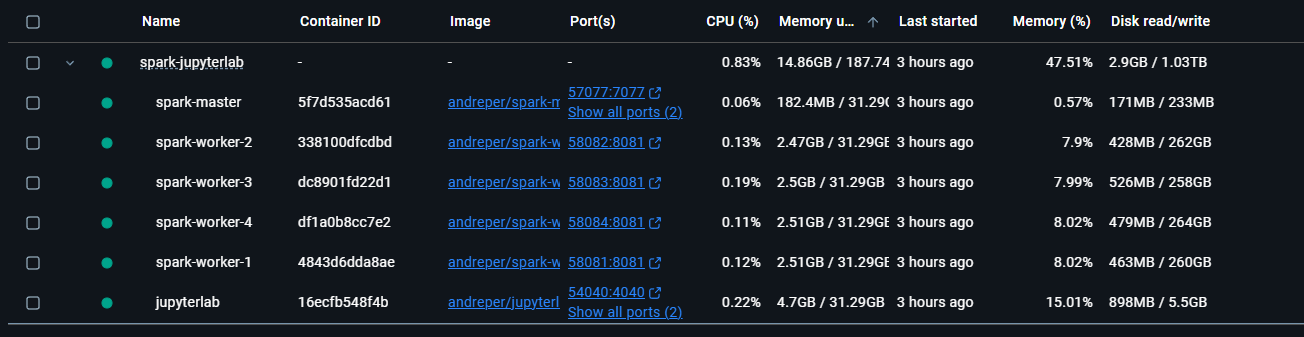

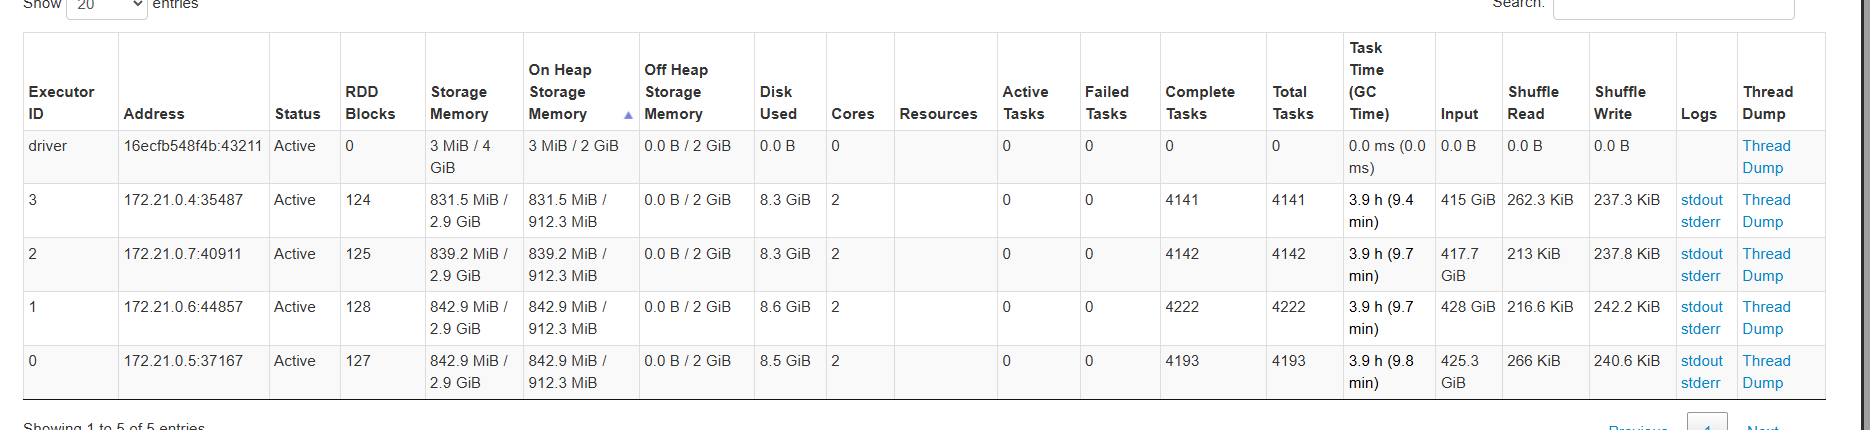

```
spark-worker-3 # du -sh /tmp
8.5G    /tmp
```


In [12]:
from pyspark.storagelevel import StorageLevel

print(dir(StorageLevel))

['DISK_ONLY', 'DISK_ONLY_2', 'MEMORY_AND_DISK', 'MEMORY_AND_DISK_2', 'MEMORY_ONLY', 'MEMORY_ONLY_2', 'OFF_HEAP', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__']


In [ ]:
from pyspark.storagelevel import StorageLevel

# 1. Загрузите исходный DataFrame (без .collect()!)
df_base = spark.read.csv('data/orders.csv', header=True, sep='\t')

# 2. Инициализируйте DataFrame, который будет расти.
#    Обязательно вызовите .cache() и .count() для первой загрузки в память исполнителей.
df_current_large = df_base.persist(StorageLevel.MEMORY_ONLY)
initial_row_count = df_current_large.count()
print(f"Исходный DataFrame загружен и кэширован на нодах. Строк: {initial_row_count}")

# 3. Цикл для постепенного увеличения DataFrame и заполнения памяти нод
iteration = 0
try:
    while True:
        iteration += 1
        print(f"\nИтерация {iteration}...")

        # Используйте .union() для объединения DataFrames по строкам.
        # Это будет удваивать количество строк в DataFrame на каждой итерации.
        df_new_large = df_current_large.union(df_base) # Добавляем исходный DF к текущему большому DF

        # Важно: Снимаем с кэша старый DataFrame, чтобы освободить память,
        # если он больше не нужен и мы хотим видеть рост только новой версии.
        df_current_large.unpersist()

        # Кэшируем новый, увеличенный DataFrame.
        df_new_large.persist(StorageLevel.MEMORY_ONLY)

        # Выполняем действие (например, count()), чтобы заставить Spark вычислить
        # и загрузить новый большой DataFrame в память исполнителей.
        new_row_count = df_new_large.count()
        print(f"Новый DataFrame создан и кэширован на нодах. Строк: {new_row_count}")

        # Проверьте Spark UI на вкладке "Executors" (http://localhost:54040/executors/)
        # и вкладке "Storage" (http://localhost:54040/storage/)
        # чтобы увидеть, как заполняется память исполнителей.

        # Обновляем ссылку на текущий большой DataFrame для следующей итерации
        df_current_large = df_new_large

except Exception as e:
    print(f"\nПроизошла ошибка (вероятно, OutOfMemoryError на исполнителях): {e}")
    # Здесь можно добавить логику для сохранения состояния или анализа ошибки

finally:
    print(f"Финальное количество строк в DataFrame: {df_current_large.count()}")
    df_current_large.unpersi

Исходный DataFrame загружен и кэширован на нодах. Строк: 3600000

Итерация 1...


Новый DataFrame создан и кэширован на нодах. Строк: 7200000

Итерация 2...


Новый DataFrame создан и кэширован на нодах. Строк: 10800000

Итерация 3...


Новый DataFrame создан и кэширован на нодах. Строк: 14400000

Итерация 4...


25/07/17 23:02:50 WARN CacheManager: Asked to cache already cached data.        


Новый DataFrame создан и кэширован на нодах. Строк: 18000000

Итерация 5...


Новый DataFrame создан и кэширован на нодах. Строк: 21600000

Итерация 6...


Новый DataFrame создан и кэширован на нодах. Строк: 25200000

Итерация 7...


Новый DataFrame создан и кэширован на нодах. Строк: 28800000

Итерация 8...


Новый DataFrame создан и кэширован на нодах. Строк: 32400000

Итерация 9...


Новый DataFrame создан и кэширован на нодах. Строк: 36000000

Итерация 10...


Новый DataFrame создан и кэширован на нодах. Строк: 39600000

Итерация 11...


Новый DataFrame создан и кэширован на нодах. Строк: 43200000

Итерация 12...


Новый DataFrame создан и кэширован на нодах. Строк: 46800000

Итерация 13...


Новый DataFrame создан и кэширован на нодах. Строк: 50400000

Итерация 14...


Новый DataFrame создан и кэширован на нодах. Строк: 54000000

Итерация 15...


Новый DataFrame создан и кэширован на нодах. Строк: 57600000

Итерация 16...


Новый DataFrame создан и кэширован на нодах. Строк: 61200000

Итерация 17...


Новый DataFrame создан и кэширован на нодах. Строк: 64800000

Итерация 18...


Новый DataFrame создан и кэширован на нодах. Строк: 68400000

Итерация 19...


Новый DataFrame создан и кэширован на нодах. Строк: 72000000

Итерация 20...


Новый DataFrame создан и кэширован на нодах. Строк: 75600000

Итерация 21...


Новый DataFrame создан и кэширован на нодах. Строк: 79200000

Итерация 22...


Новый DataFrame создан и кэширован на нодах. Строк: 82800000

Итерация 23...


Новый DataFrame создан и кэширован на нодах. Строк: 86400000

Итерация 24...


Новый DataFrame создан и кэширован на нодах. Строк: 90000000

Итерация 25...
